In [2]:
import pandas as pd
import os
import glob
import re
import functools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.chdir("/fs/scratch/PAS0439/Ming/virome_ecology_core_prkaryotes/scripts/02_kraken2_mapping/slurm_out/")

In [4]:
rumenmags3588 = glob.glob("k2_benchmark_gtdb207_rumenmags3588*")

In [5]:
rumenmags7166 = glob.glob("k2_benchmark_gtdb207_rumenmagsfull*")

In [6]:
standard = glob.glob("k2_benchmark_standard*")

In [7]:
gtdb = glob.glob("k2_benchmark_gtdb207_[0-9]*.out")

In [8]:
dataset_list = [rumenmags3588, rumenmags7166, standard, gtdb]
def output_classification_rate(dataset):
    sample_list = []
    classification_list = []
    for f in dataset:
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                sample_match = re.match("(.*)_1.fastq_clean.gz", line)
                classification_rate_match = re.match(".* sequences classified \(([0-9.]*)%\)", line)
                if sample_match:
                    sample = sample_match.group(1)
                    sample_list.append(sample)
                elif classification_rate_match:
                    classification_rate = classification_rate_match.group(1)
                    classification_list.append(float(classification_rate))
                else:
                    continue
    mydir = {}
    for f in range(len(sample_list)):
        mydir[sample_list[f]] = classification_list[f]
    return mydir
    
rumenmags3588_dir = output_classification_rate(rumenmags3588)
rumenmags7166_dir = output_classification_rate(rumenmags7166)
standard_dir = output_classification_rate(standard)
gtdb_dir = output_classification_rate(gtdb)
    
rumenmags3588_df = pd.DataFrame.from_dict(rumenmags3588_dir, orient='index')
rumenmags3588_df.rename(columns={0:"gtdb+3588"}, inplace = True)
rumenmags7166_df = pd.DataFrame.from_dict(rumenmags7166_dir, orient='index')
rumenmags7166_df.rename(columns={0:"gtdb+7166"}, inplace = True)
standard_df = pd.DataFrame.from_dict(standard_dir, orient='index')
standard_df.rename(columns={0:"standard"}, inplace = True)
gtdb_df = pd.DataFrame.from_dict(gtdb_dir, orient='index')
gtdb_df.rename(columns={0:"gtdb"}, inplace = True)
   
    
df_list = [standard_df, gtdb_df, rumenmags3588_df, rumenmags7166_df]

In [9]:
mapping_res = ft.reduce(lambda left, right: pd.merge(left, right, left_index= True, right_index = True), df_list).reset_index()

In [10]:
mapping_res_plot = pd.melt(mapping_res, id_vars='index', value_vars=['standard', 'gtdb', 'gtdb+3588', 'gtdb+7166'])

In [11]:
mapping_res_plot

,index,variable,value
0,SRR8704694,standard,15.53
1,SRR10765506,standard,15.58
2,SRR10765526,standard,18.82
3,SRR10765504,standard,20.12
4,SRR10765519,standard,17.04
...,...,...,...
191,SRR8703775,gtdb+7166,76.58
192,SRR8698064,gtdb+7166,76.72
193,SRR10765532,gtdb+7166,79.33
194,SRR10765529,gtdb+7166,74.95


[Text(0.5, 0, 'classifier'), Text(0, 0.5, 'classification rate (%)')]

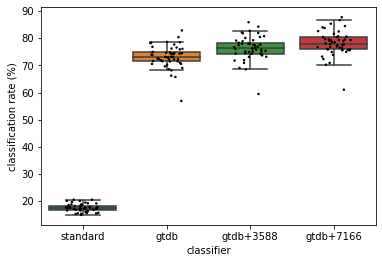

In [12]:
ax = sns.boxplot(x = 'variable', y='value', data= mapping_res_plot, fliersize = 0)
ax = sns.stripplot(x = 'variable', y='value', data= mapping_res_plot, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='classifier', ylabel='classification rate (%)')
